<a href="https://colab.research.google.com/github/who-knows-its-nebulose/Chair_Style_classifier/blob/main/Train_chair_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2216 files belonging to 5 classes.
Using 1773 files for training.
Found 2216 files belonging to 5 classes.
Using 443 files for validation.
['Farmhouse', 'Industrial', 'Midcentury', 'Tropical', 'Victorian']


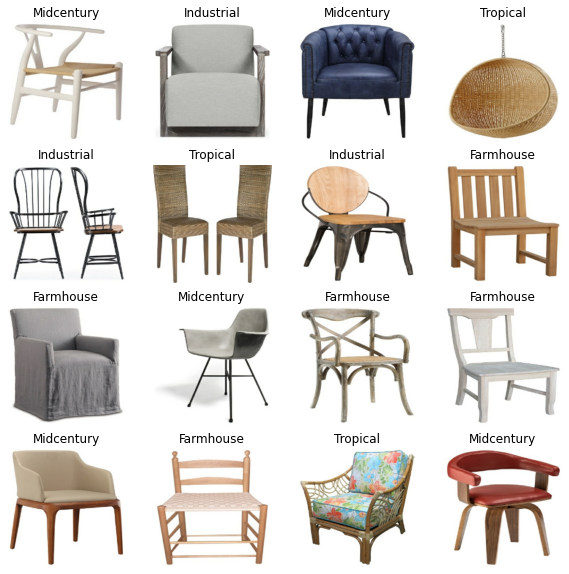

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



#Import libraries
import os
import numpy as np
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


#variables
img_height = 224
img_width = 224
batch_size = 32

N_CLASSES = 5
TOTAL_EPOCHS = 50

#path
dataset_path = '/content/drive/My Drive/colabdownloads/chairs/'

#importing data


ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels = 'inferred',
    label_mode = "categorical",
    class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "training",
)

ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels = 'inferred',
    label_mode = "categorical",
    class_names= ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
)

class_names = ds_train.class_names
print(class_names)

#look at the dataset

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
    int_labels = np.argmax(labels, axis=-1)
    plt.title(class_names[int_labels[i]])
    plt.axis("off")



buffer autotune


In [ ]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# ds_train = ds_train.prefetch(buffer_size=AUTOTUNE) 
# ds_valid = ds_valid.prefetch(buffer_size=AUTOTUNE)

PREPROCESS and AUGMENT , make it part of the model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6

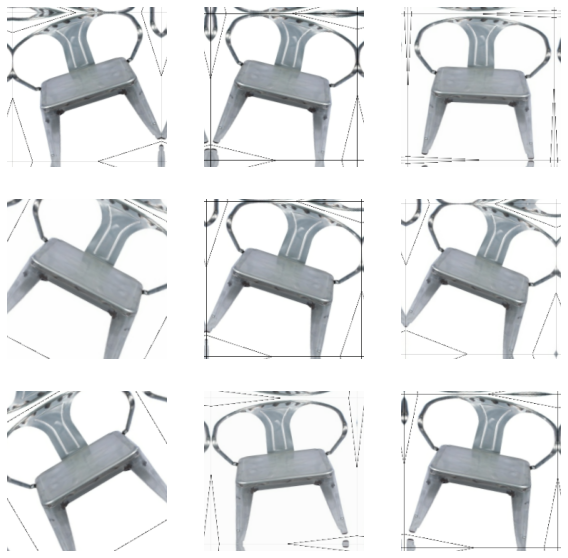

In [ ]:
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

img_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

#look at augmented images
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet',
                                               alpha = 1.4)


base_model.trainable = False


#build model

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
aug_images = img_augmentation(inputs)
preprocessed_input = preprocess_input(aug_images)
base_model_out = base_model(preprocessed_input, training=False)
Pooled = GlobalAveragePooling2D()(base_model_out)
drop1 = Dropout(0.2)(Pooled)
dense1 = Dense(256, activation = 'relu')(drop1)
drop2 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation = 'relu')(drop2)
drop3 = Dropout(0.2)(dense2)
outputs = Dense(5, activation='softmax')(drop3)
model = tf.keras.Model(inputs, outputs)


len(model.trainable_variables)



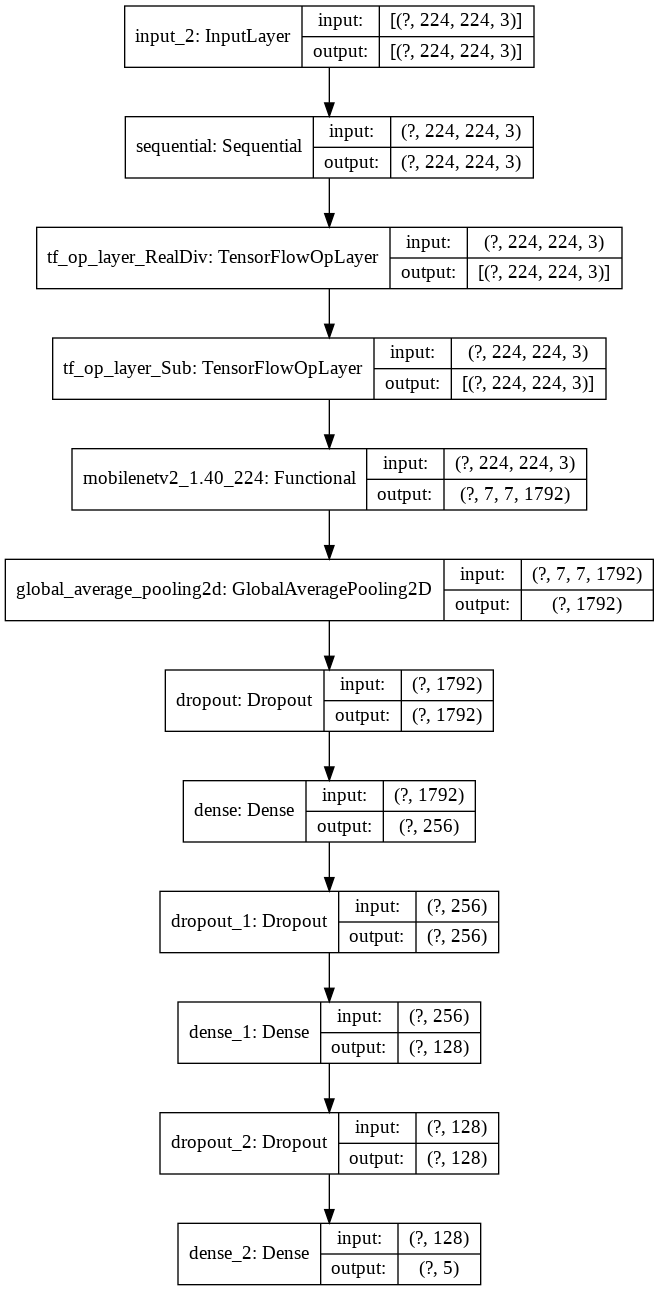

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names= True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/checkpoints/{epoch:02d}_{val_accuracy:.4f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True)   
 
reduce_lr =  ReduceLROnPlateau(patience=4, monitor='val_accuracy', factor = 0.5 , min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True, mode='max',verbose=1,min_delta=0.004)
          
Callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]    



In [ ]:
TRAIN_DATASET_SIZE = len(ds_train)
VAL_DATASET_SIZE   = len(ds_valid)

# Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.class_names, return_counts=True)
# class_weights = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))
#/content/drive/My Drive/Colab Notebooks


# Prepare model to run
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
INITIAL_EPOCH = 0
# Starts training the model
history = model.fit(ds_train,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=ds_valid,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.5268
Epoch 00001: val_accuracy improved from -inf to 0.70429, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/01_0.7043.h5
56/56 [==============================] - 8s 144ms/step - loss: 1.1773 - accuracy: 0.5268 - val_loss: 0.7731 - val_accuracy: 0.7043
Epoch 2/50
54/56 [===========================>..] - ETA: 0s - loss: 0.7928 - accuracy: 0.7078
Epoch 00002: val_accuracy improved from 0.70429 to 0.75395, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/02_0.7540.h5
56/56 [==============================] - 7s 126ms/step - loss: 0.7936 - accuracy: 0.7067 - val_loss: 0.6464 - val_accuracy: 0.7540
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.7417
Epoch 00003: val_accuracy did not improve from 0.75395
56/56 [==============================] - 7s 120ms/step - loss: 0.6886 - accuracy: 0.7417 - val_loss: 0.6589 - val_accuracy

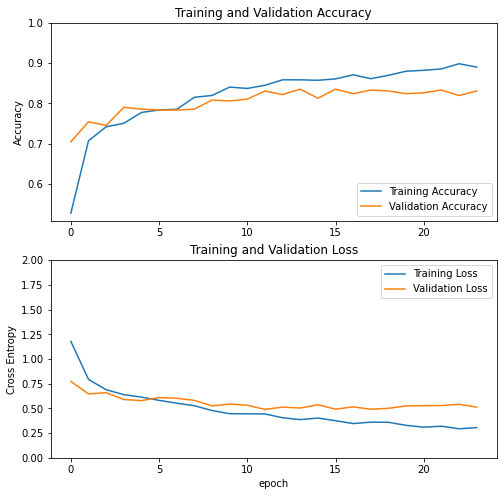

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [ ]:
chair_checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints/'
if Path(chair_checkpoint_path).exists():
  epoch_number_array = []
  val_accuracy_array = []
  file_name_array = []
  for file in os.listdir(chair_checkpoint_path):
      epoch, val_ac = re.search(r'(\d\d)_(\d\.\d{4})\.h5', file).group(1,2)
      epoch_number_array.append(int(epoch))
      val_accuracy_array.append(float(val_ac))
      file_name_array.append(file)

      if len(val_accuracy_array) == 0:
        INITIAL_EPOCH = 0
      else:
        highest_acc = val_accuracy_array.index(max(val_accuracy_array))
        INITIAL_EPOCH = epoch_number_array[highest_acc]
        model_checkpoint_callback.best = val_accuracy_array[highest_acc]
        model.load_weights(chair_checkpoint_path + file_name_array[highest_acc])
else:
  os.makedirs(chair_checkpoint_path)
  INITIAL_EPOCH = 0



In [ ]:
print(val_accuracy_array[highest_acc])
print(INITIAL_EPOCH)

0.8352
14


FINE TUNE

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_learning_rate = 0.001

model.compile(optimizer = Adam(learning_rate=base_learning_rate/100),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
model.summary()

len(model.trainable_variables)

Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Drop

62

In [ ]:
history_fine = model.fit(ds_train,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=ds_valid,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 15/50
56/56 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8511
Epoch 00015: val_accuracy improved from 0.83520 to 0.84650, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/15_0.8465.h5
56/56 [==============================] - 8s 152ms/step - loss: 0.4078 - accuracy: 0.8511 - val_loss: 0.4596 - val_accuracy: 0.8465
Epoch 16/50
56/56 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8663
Epoch 00016: val_accuracy did not improve from 0.84650
56/56 [==============================] - 7s 130ms/step - loss: 0.3746 - accuracy: 0.8663 - val_loss: 0.4912 - val_accuracy: 0.8397
Epoch 17/50
56/56 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8754
Epoch 00017: val_accuracy did not improve from 0.84650
56/56 [==============================] - 7s 130ms/step - loss: 0.3383 - accuracy: 0.8754 - val_loss: 0.4965 - val_accuracy: 0.8307
Epoch 18/50
56/56 [==============================] - ETA: 0s - loss: 0.

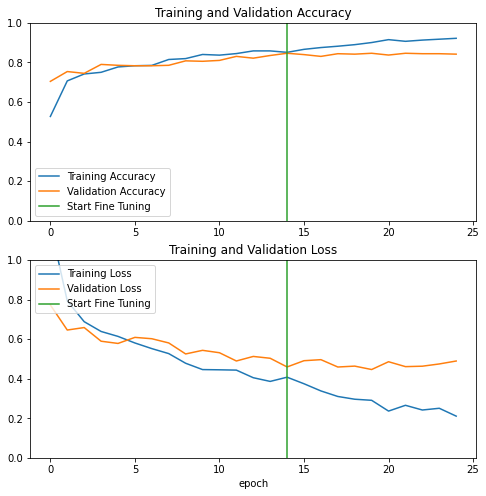

In [90]:
acc[INITIAL_EPOCH:] = history_fine.history['accuracy']
val_acc[INITIAL_EPOCH:]= history_fine.history['val_accuracy']

loss[INITIAL_EPOCH:]= history_fine.history['loss']
val_loss[INITIAL_EPOCH:]= history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCH,INITIAL_EPOCH],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCH, INITIAL_EPOCH],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [91]:
model.save('/content/drive/My Drive/ML_models/chair_classifier/model_chair_classifier_finetuned84.h5')


Enter your URLhttps://st.hzcdn.com/simgs/fc1185730848760a_4-2323/home-design.jpg
[[0.18187445 0.49483907 0.18271373 0.12313695 0.01743583]]
Industrial


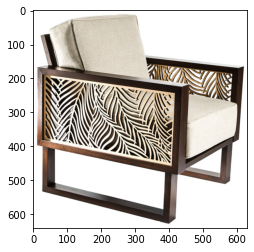

In [92]:
#TEST
from keras.models import load_model
from keras.preprocessing import image
from skimage.io import imread
from skimage.transform import rescale, resize

model_trained = load_model('/content/drive/My Drive/ML_models/chair_classifier/model_chair_classifier_finetuned84.h5')

url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = class_names[max_prob_index[0]]
print(prediction)
